## Forecasting Using ARIMA model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
store_df = pd.read_excel("data/store.xls")

In [3]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
Date      115 non-null datetime64[ns]
demand    115 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


In [4]:
store_df.head()

,Date,demand
0,2014-10-01,15
1,2014-10-02,7
2,2014-10-03,8
3,2014-10-04,10
4,2014-10-05,13


In [5]:
store_df.set_index(pd.to_datetime(store_df.Date),inplace=True)
store_df.head()

,Date,demand
Date,,
2014-10-01,2014-10-01,15
2014-10-02,2014-10-02,7
2014-10-03,2014-10-03,8
2014-10-04,2014-10-04,10
2014-10-05,2014-10-05,13


In [6]:
store_df.drop('Date',axis=1, inplace=True)

In [7]:
store_df.head()

,demand
Date,
2014-10-01,15
2014-10-02,7
2014-10-03,8
2014-10-04,10
2014-10-05,13


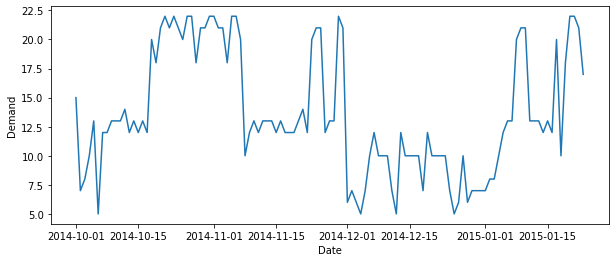

In [8]:
plt.figure(figsize=(10,4))
plt.xlabel("Date")
plt.ylabel("Demand")
plt.plot(store_df.demand)


In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

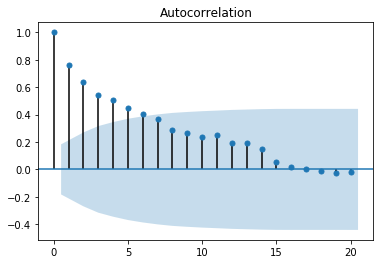

In [10]:
acf_plot = plot_acf(store_df.demand, lags=20)

### Note: In the acf plot , the slow decline of auto correlation for different lags shows that the series is not stationary

In [11]:
## Dicky - Fuller Test to test if time series is stationary
## H0: Beta =1 (the time series is non-stationary)
## H1: Beta <1 (the time series is stationary)

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
def adfuller_test(ts):
    adfuller_result = adfuller(ts,autolag=None)
    adfuller_out = pd.Series(adfuller_result[0:4],
                            index = ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    print(adfuller_out)
 

In [14]:
adfuller_test(store_df.demand)

Test Statistic                  -1.649533
p-value                          0.457284
Lags Used                       13.000000
Number of Observations Used    101.000000
dtype: float64


## The p-value > 4 indicates that we cannot reject the null hypothesis, ie, the time series data is non stationary

## Differencing to convert non-stationary process to stationary process

In [15]:
store_df['demand_diff'] = store_df.demand - store_df.demand.shift(1)

In [16]:
store_df.head()

,demand,demand_diff
Date,,
2014-10-01,15,NaN
2014-10-02,7,-8.0
2014-10-03,8,1.0
2014-10-04,10,2.0
2014-10-05,13,3.0


In [17]:
store_diff_df = store_df.dropna()
store_diff_df

,demand,demand_diff
Date,,
2014-10-02,7,-8.0
2014-10-03,8,1.0
2014-10-04,10,2.0
2014-10-05,13,3.0
2014-10-06,5,-8.0
...,...,...
2015-01-19,18,8.0
2015-01-20,22,4.0
2015-01-21,22,0.0


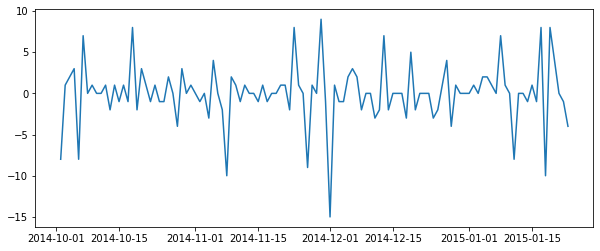

In [18]:
plt.figure(figsize=(10,4))
plt.xlabel=("Date")
plt.ylabel=("First Order Differences")
plt.plot(store_diff_df.demand_diff)

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

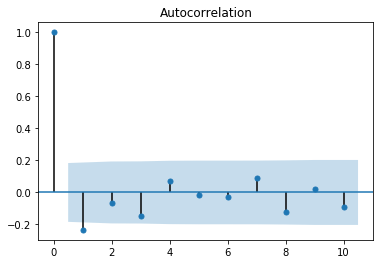

In [20]:
acf_plot = plot_acf(store_diff_df.demand_diff, lags=10)

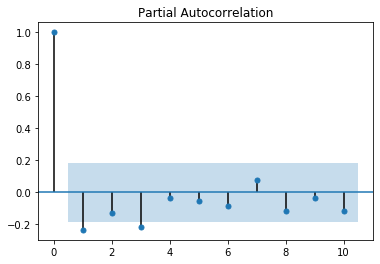

In [21]:
pacf_plot = plot_pacf(store_diff_df.demand_diff, lags=10)

## Note: Now the figure shows no slow reduction of auto correlation over the lags. and it immedately cut offs to zero.

## Model buiding

In [22]:
store_train = store_df[0:100]
store_test = store_df[100:]

In [26]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(store_train.demand.astype('float64').as_matrix(), order=(1,1,1))
arima_model = arima.fit()

In [27]:
arima_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: ARIMA
==================================================================
Model:              ARIMA            BIC:                 528.1168
Dependent Variable: D.y              Log-Likelihood:      -254.87 
Date:               2019-11-29 11:48 Scale:               1.0000  
No. Observations:   99               Method:              css-mle 
Df Model:           3                Sample:              1       
Df Residuals:       96                                    0       
Converged:          1.0000           S.D. of innovations: 3.173   
No. Iterations:     10.0000          HQIC:                521.936 
AIC:                517.7364                                      
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const           0.1003    0.1787   0.5611  0.5760  -0.2500   0.4505
ar.L1.D.y       0.4028    0.2272   1.7730  0.0794  -0.0425   0.8481
ma.L1.D.y      -0.6739    0.1855  -3.6323  0.0005  -1.0375  -0.3103
---------------------------------------------------------------------------
               Real           Imaginary          Modulus          Frequency
---------------------------------------------------------------------------
AR.1          2.4826             0.0000           2.4826             0.0000
MA.1          1.4839             0.0000           1.4839             0.0000
==================================================================

"""

### ARIMA model is a regression model , thus has to satisfy the regression assumptions of Regression. The residuals should not be correlated.


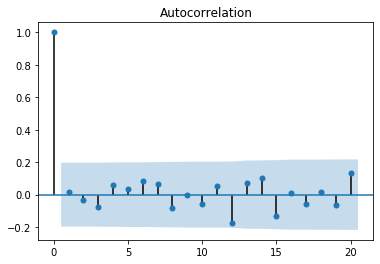

In [28]:
## Plot acf and pacf of residuals to check the residuals
acf_plot = plot_acf(arima_model.resid, lags=20)

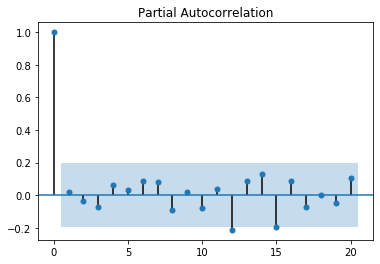

In [29]:
pacf_plot = plot_pacf(arima_model.resid, lags=20)

### Forecasting and Accuracy Measure


In [32]:
store_predict, stderr, ci = arima_model.forecast(steps =15)

In [33]:
store_predict

array([19.34768741, 18.74201064, 18.55791982, 18.54364424, 18.59777041,
       18.67944886, 18.77222542, 18.86947229, 18.96851981, 19.06829264,
       19.16835762, 19.26854028, 19.36877034, 19.46901949, 19.56927634])

In [34]:
def get_mape(actual, predicted):
    return np.round(np.mean(np.abs((actual - predicted))/actual)*100, 2)

In [44]:
get_mape(store_df.demand[100:],store_predict)

30.23